In [108]:
import pandas as pd
import os
import numpy as np
import pickle
import json
import scipy
import matplotlib.pyplot as plt
import shutil
from skimage.measure import regionprops
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import sys
import string
from PIL import Image
from scipy import signal
from scipy.interpolate import interp1d
from skimage import measure
import seaborn as sns
from scipy import stats
from skimage.draw import rectangle
import importlib
import splitfolders
from scipy.stats import gaussian_kde


import plots
import df_utils
importlib.reload(df_utils)
import features
import Figure2plots
importlib.reload(Figure2plots)

<module 'Figure2plots' from 'C:\\Users\\codyt\\Documents\\repos\\time-series-dc\\Figure2plots.py'>

In [2]:
df = pd.read_pickle('D://Datasets//full_data101x56_2_xc_fixed_calcs')
df = df_utils.filter_df(df,ymax=5,max_ar=1.1,radius_std=3)
df = df[(df.cell=='hl60')|(df.cell=='hl60d')]
df = df[np.logical_not((df.cell=='hl60')&(df.date=='11-3-20')&(df.run=='0'))]
df = df[np.logical_not((df.cell=='hl60')&(df.date=='11-5-20')&(df.run=='3'))]
print(len(df))

Length prefilter: 2337
Length postfilter: 1925
1501


In [64]:
df.columns

Index(['event', 'tf', 'mask', 'perimeter', 'area', 'circ', 'deform', 'r_um',
       'xcm_um', 'yc_um', 'perimeter_cx', 'area_cx', 'circ_cx', 'deform_cx',
       'r_um_cx', 'xc_um_el', 'yc_um_el', 'a', 'b', 'aspect', 'r_um_el',
       'cell', 'date', 'run', 'r_idx', 'nar1_idx', 'nar2_idx', 'cav_idx',
       'out1_idx', 'out2_idx', 'rad', 'nar1_def', 'nar2_def', 'cav1_def',
       'r_el', 'nar1_asp', 'nar2_asp', 'cav1_asp', 'nar1_max_arg',
       'nar2_max_arg', 'cav1_min_arg', 'x_poly1', 'x_poly2', 'x_poly3',
       'region1_dx', 'region1_dt', 'region1_dasp', 'delta_asp', 'v_avg',
       'mean_area', 'mean_perimeter', 'mean_aspect', 'r1_slope', 'r2_slope'],
      dtype='object')

In [4]:
df['r1_slope']=df.apply(lambda a: a.x_poly1[0],axis=1)
df['r2_slope']=df.apply(lambda a: a.x_poly2[0],axis=1)

In [18]:
nar1_mean = np.mean(df[df.cell=='hl60'].nar1_asp)
nar1_std = np.std(df[df.cell=='hl60'].nar1_asp)
nar1_sem = stats.sem(df[df.cell=='hl60'].nar1_asp)

In [23]:
nar2_mean = np.mean(df[df.cell=='hl60'].nar2_asp)
nar2_std = np.std(df[df.cell=='hl60'].nar2_asp)
nar2_sem = stats.sem(df[df.cell=='hl60'].nar2_asp)

In [20]:
r1_mean = np.mean(df[df.cell=='hl60'].r1_slope)
r1_std = np.std(df[df.cell=='hl60'].r1_slope)
r1_sem = stats.sem(df[df.cell=='hl60'].r1_slope)

C:\Users\codyt\.conda\envs\aktwelve\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\codyt\.conda\envs\aktwelve\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparen

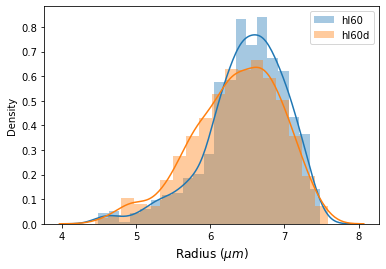

In [6]:
sns.distplot(df[df.cell=='hl60'].rad,label='hl60')
sns.distplot(df[df.cell=='hl60d'].rad,label='hl60d')
plt.xlabel('Radius ($\mu m$)',fontsize=12)
plt.legend()
plt.savefig('./figures/SI/radius_dist.eps',format='eps')

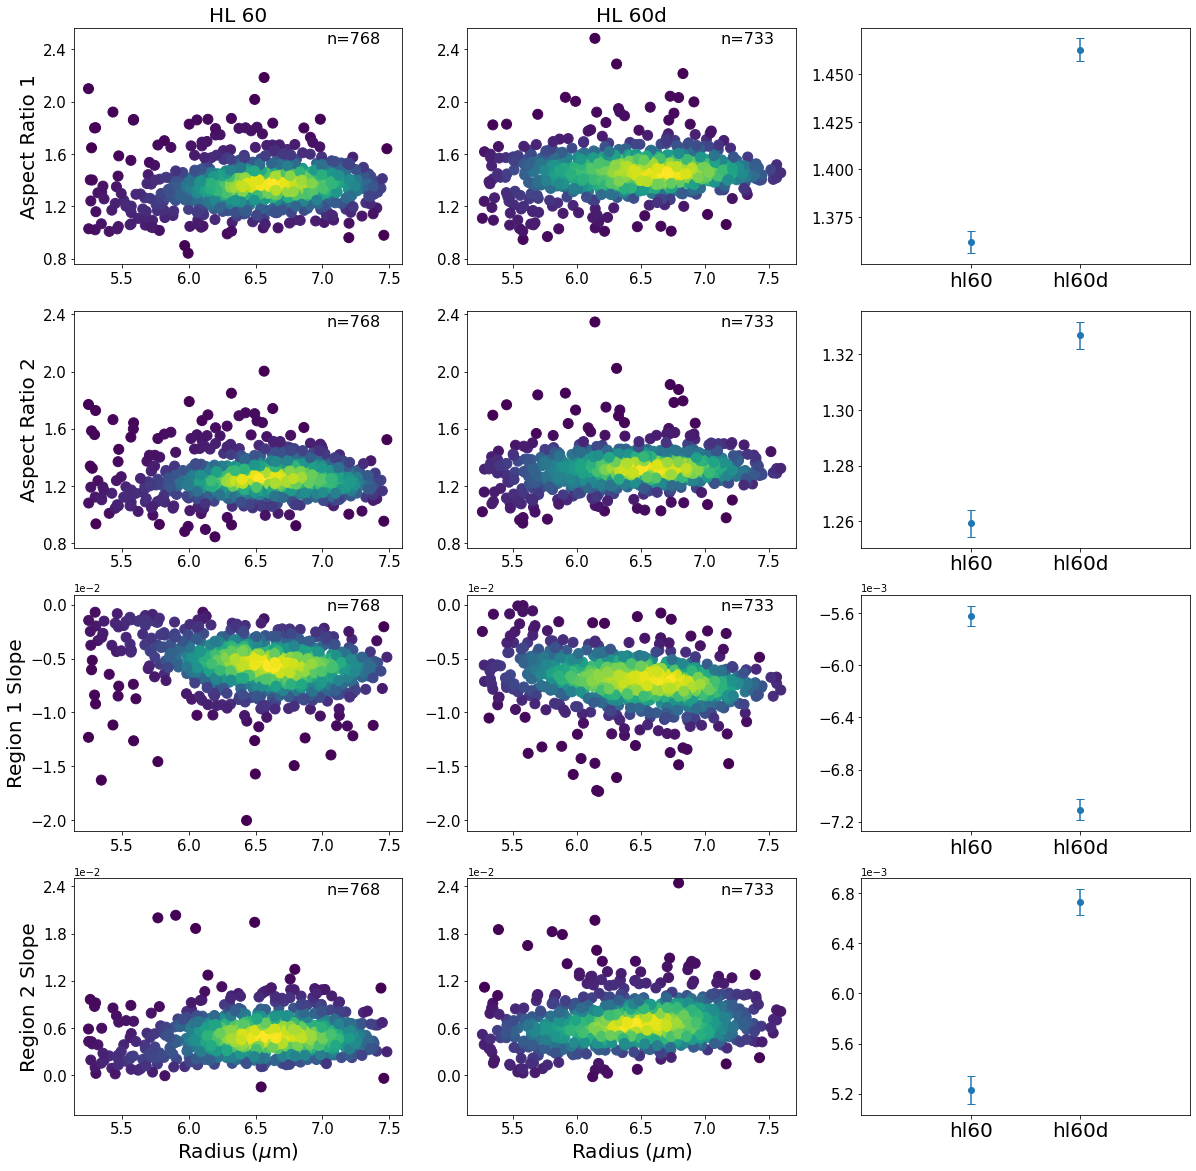

In [95]:
Figure2plots.heatmap_pop_full(df,'rad',['nar1_asp','nar2_asp','r1_slope','r2_slope'],
                              ['Aspect Ratio 1','Aspect Ratio 2', 'Region 1 Slope','Region 2 Slope'],
                              'Radius ($\mu $m)',output_path='./figures/figure2/heatmaps_mean.png',save=True)

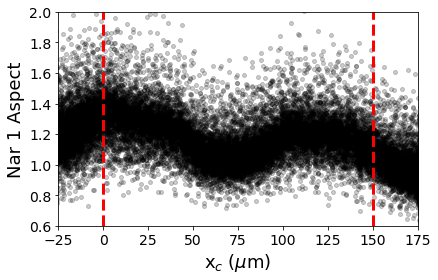

In [11]:
Figure2plots.feat_x(df,'./figures/heatmaps_mean.png','hl60','Nar 1 Aspect',feature='aspect',save=False)

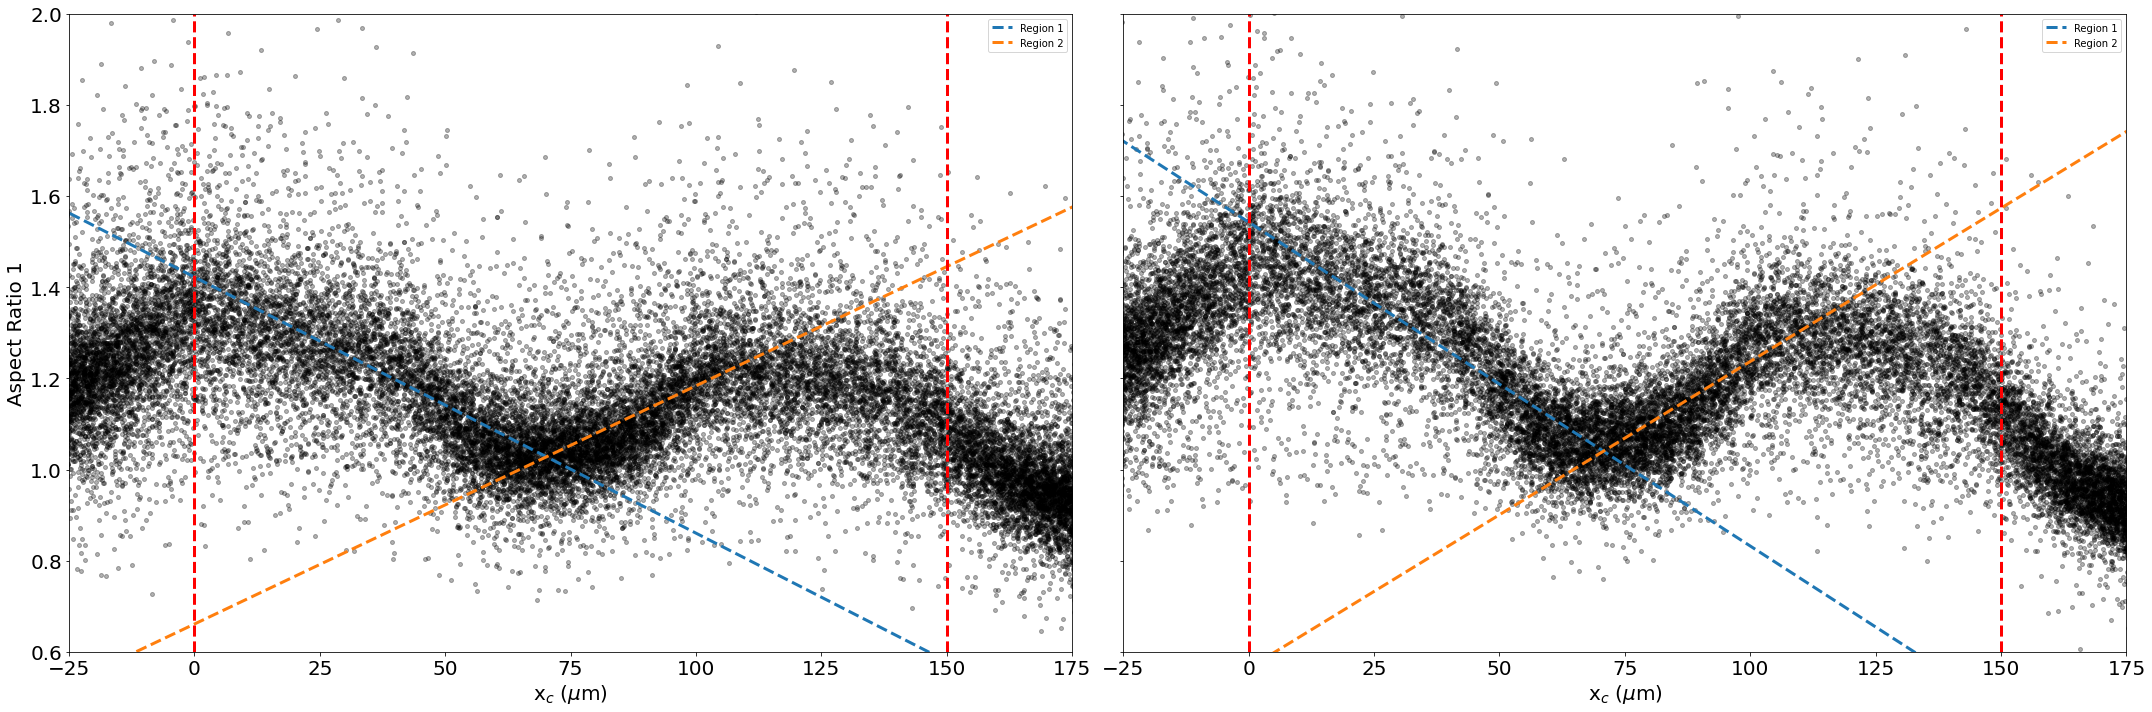

In [109]:
Figure2plots.feat_x_sub(df,'./figures/figure2/heatmaps_mean.png','Aspect Ratio 1',feature='aspect',trend=True,save=True)

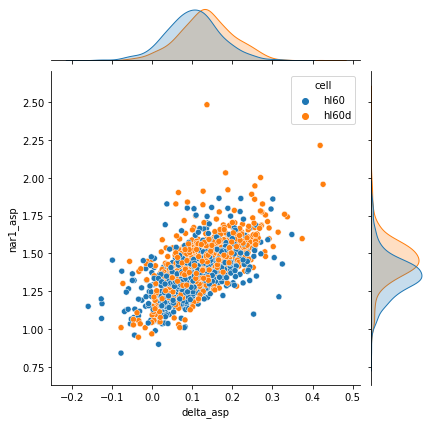

In [86]:
sns.jointplot(
    data=df,
    x="delta_asp", y="nar1_asp", hue="cell"
)

In [63]:
axs.shape

(2,)

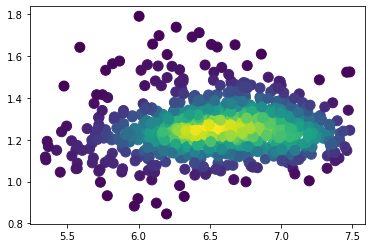

In [27]:
# Generate fake data
x = df[df.cell=='hl60']['rad'].to_numpy()
y = df[df.cell=='hl60']['nar2_asp'].to_numpy()

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor=None)
plt.show()

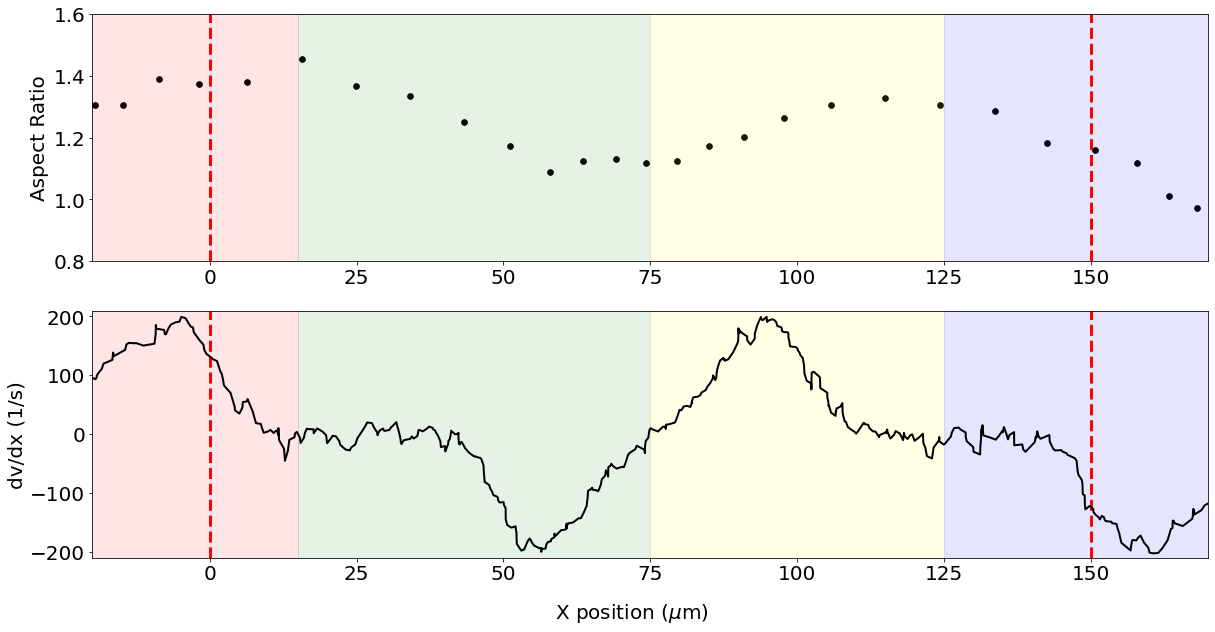

In [22]:
Figure2plots.aspect_dvdx_x(df,'./figures/aspect_dvdx.png',save=True)

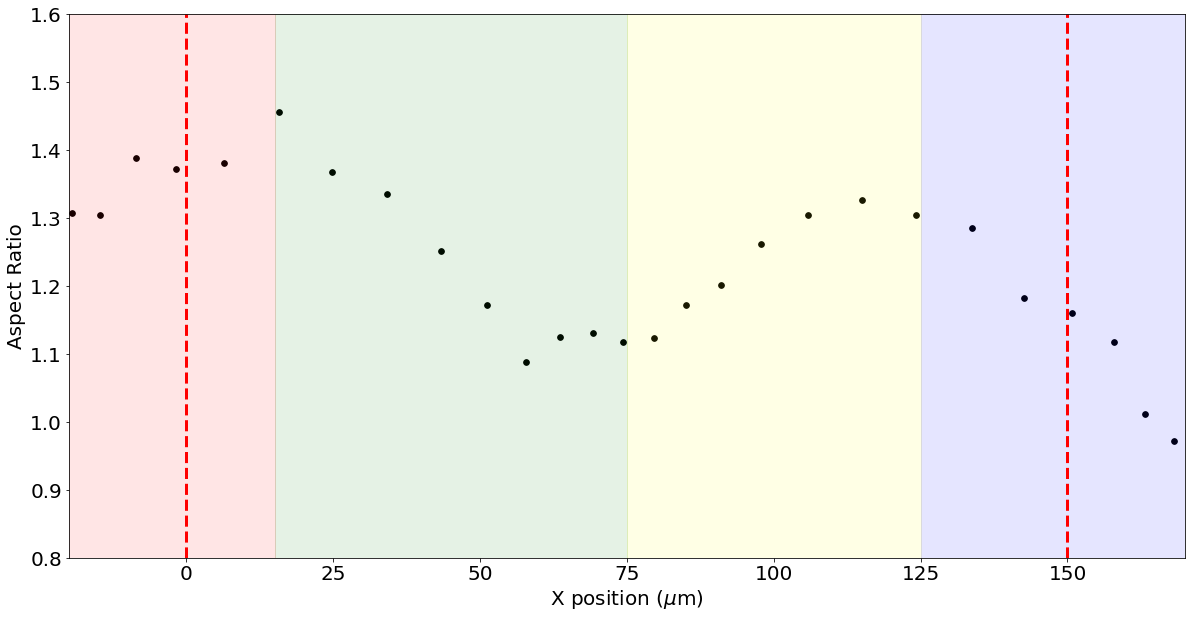

In [24]:
Figure2plots.aspect_x(df,'./figures/figure1/aspect_x.png',save=True)

In [50]:
df_cm = pd.read_csv('C://Users//codyt//Desktop//comsol//sheath_particle//bare_channel//velocity.csv',skiprows=8)[0:-2]
df_cm = df_cm.drop(df_cm.columns[-1],axis=1)
df_cm = df_cm.rename(columns={df_cm.columns[4]: 'u',df_cm.columns[5]: 'x', df_cm.columns[6]: "dudx",df_cm.columns[3]:'sr'})
df_cm = df_cm.sort_values(by ='x' )

In [3]:
df.columns

Index(['event', 'tf', 'mask', 'perimeter', 'area', 'circ', 'deform', 'r_um',
       'xcm_um', 'yc_um', 'perimeter_cx', 'area_cx', 'circ_cx', 'deform_cx',
       'r_um_cx', 'xc_um_el', 'yc_um_el', 'a', 'b', 'aspect', 'r_um_el',
       'cell', 'date', 'run', 'r_idx', 'nar1_idx', 'nar2_idx', 'cav_idx',
       'out1_idx', 'out2_idx', 'rad', 'nar1_def', 'nar2_def', 'cav1_def',
       'r_el', 'nar1_asp', 'nar2_asp', 'cav1_asp', 'nar1_max_arg',
       'nar2_max_arg', 'cav1_min_arg', 'x_poly1', 'x_poly2', 'region1_dx',
       'region1_dt', 'region1_dasp', 'delta_asp', 'v_avg', 'mean_area',
       'mean_perimeter', 'mean_aspect'],
      dtype='object')

C:\Users\codyt\.conda\envs\aktwelve\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\codyt\.conda\envs\aktwelve\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


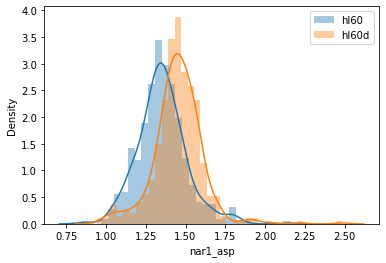

In [43]:
Figure2plots.pop_hist(df,'D://','nar1_asp',save=False)

In [32]:
df.columns

Index(['event', 'tf', 'mask', 'perimeter', 'area', 'circ', 'deform', 'r_um',
       'xcm_um', 'yc_um', 'perimeter_cx', 'area_cx', 'circ_cx', 'deform_cx',
       'r_um_cx', 'xc_um_el', 'yc_um_el', 'a', 'b', 'aspect', 'r_um_el',
       'cell', 'date', 'run', 'r_idx', 'nar1_idx', 'nar2_idx', 'cav_idx',
       'out1_idx', 'out2_idx', 'rad', 'nar1_def', 'nar2_def', 'cav1_def',
       'r_el', 'nar1_asp', 'nar2_asp', 'cav1_asp', 'nar1_max_arg',
       'nar2_max_arg', 'cav1_min_arg', 'x_poly1', 'x_poly2', 'region1_dx',
       'region1_dt', 'region1_dasp', 'delta_asp', 'v_avg', 'mean_area',
       'mean_perimeter', 'mean_aspect'],
      dtype='object')

In [50]:
df_utils.save_mask_images(df,root_path = 'D://cavity_images//mask_bbox//')

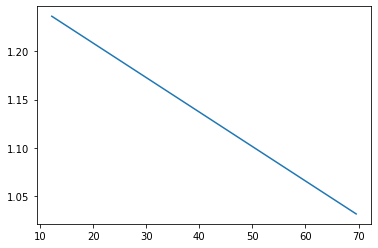

In [142]:
trend = df.iloc[0].x_poly1
trendpoly = np.poly1d(trend) 
xs = df.iloc[0].xcm_um[df.iloc[0].nar1_max_arg:df.iloc[0].cav1_min_arg]
plt.plot(xs,trendpoly(xs))
plt.show()

In [141]:
df.iloc[0].x_poly1

array([-0.00357067,  1.27985564])

In [135]:
df.iloc[0].aspect[df.iloc[0].nar1_max_arg:df.iloc[0].cav1_min_arg]

array([1.21066693, 1.20468871, 1.18002756, 1.1860173 , 1.17586193,
       1.12204645, 1.05999292, 1.02816377, 1.02004493, 1.06427245])

In [91]:
df_cm.columns

Index(['% X', 'Y', 'Z', 'sr', 'u', 'x', 'dudx'], dtype='object')

In [114]:
df_cm['v_avg'] = df_cm.u.rolling(15).mean()
df_cm['dv_avg'] = df_cm.dudx.rolling(15).mean()
df_cm['sr_avg'] = df_cm.sr.rolling(15).mean()

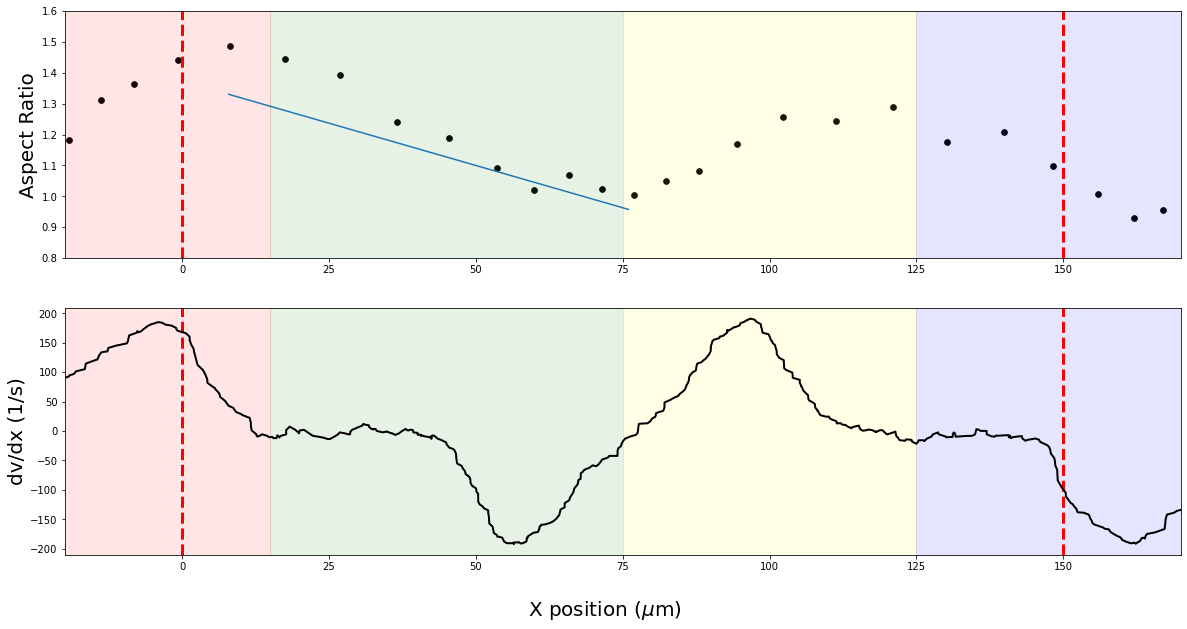

In [147]:
event_num = 193

fig, axs = plt.subplots(2,sharex=False,sharey=False,figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')

row = df[df.cell=='hl60d'].iloc[event_num]

axs[0].scatter(row.xcm_um,row.aspect,color='black',s=32)
axs[0].set_xlim([-20,170])
axs[0].set_ylim([0.8,1.6])

axs[0].set_ylabel('Aspect Ratio',size=20)


# trend = df.iloc[event_num].x_poly1
# trendpoly = np.poly1d(trend) 
# xs = df.iloc[event_num].xcm_um[df.iloc[event_num].nar1_max_arg-1:df.iloc[event_num].cav1_min_arg+1]
# axs[0].plot(xs,trendpoly(xs))

fig.text(0.5, 0.04, 'X position ($\mu$m)', ha='center',size=20)


xposition = [0,150]
for xc in xposition:
    axs[0].axvline(x=xc, color='r', linestyle='--',lw=3)
    axs[1].axvline(x=xc, color='r', linestyle='--',lw=3)

axs[1].plot(df_cm.x*1000,df_cm.dv_avg/1000,color='black',linewidth=2)
axs[1].set_xlim([-20,170])
axs[1].set_ylim([-210,210])

axs[1].set_ylabel('dv/dx (1/s)',size=20)


axs[0].axvspan(-20, 15, alpha=0.1, color='red')
axs[1].axvspan(-20, 15, alpha=0.1, color='red')

axs[0].axvspan(15, 75, alpha=0.1, color='green')
axs[1].axvspan(15, 75, alpha=0.1, color='green')

axs[0].axvspan(75, 125, alpha=0.1, color='yellow')
axs[1].axvspan(75, 125, alpha=0.1, color='yellow')

axs[0].axvspan(125, 170, alpha=0.1, color='blue')
axs[1].axvspan(125, 170, alpha=0.1, color='blue')
plt.show()

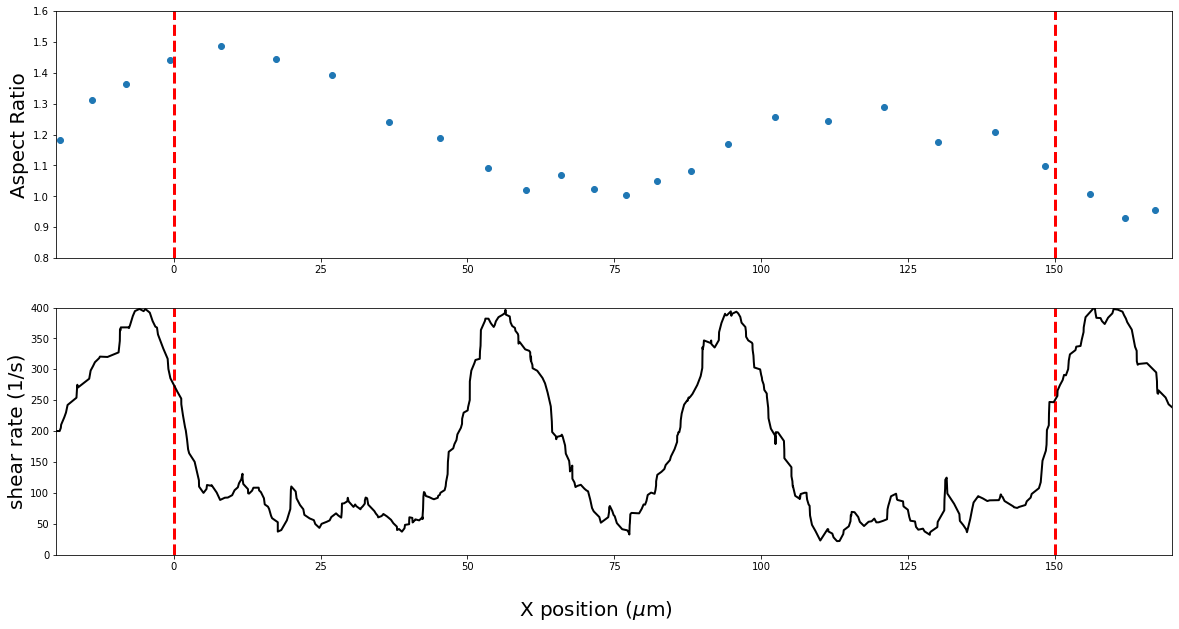

In [86]:
fig, axs = plt.subplots(2,sharex=False,sharey=False,figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')

row = df[df.cell=='hl60d'].iloc[193]

axs[0].scatter(row.xcm_um,row.aspect)
axs[0].set_xlim([-20,170])
axs[0].set_ylim([0.8,1.6])

axs[0].set_ylabel('Aspect Ratio',size=20)

fig.text(0.5, 0.04, 'X position ($\mu$m)', ha='center',size=20)


xposition = [0,150]
for xc in xposition:
    axs[0].axvline(x=xc, color='r', linestyle='--',lw=3)
    axs[1].axvline(x=xc, color='r', linestyle='--',lw=3)

axs[1].plot(df_cm.x*1000,df_cm.sr_avg/1000,color='black',linewidth=2)
axs[1].set_xlim([-20,170])
axs[1].set_ylim([0,400])

axs[1].set_ylabel('shear rate (1/s)',size=20)

plt.show()

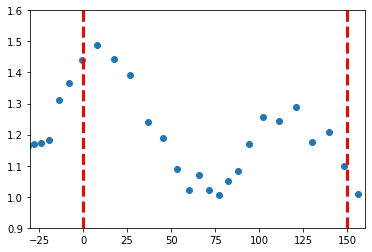

In [33]:
row = df[df.cell=='hl60d'].iloc[193]

plt.scatter(row.xcm_um,row.aspect)

plt.xlim(-30,160)
plt.ylim(.9,1.6)

xposition = [0,150]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--',lw=3)

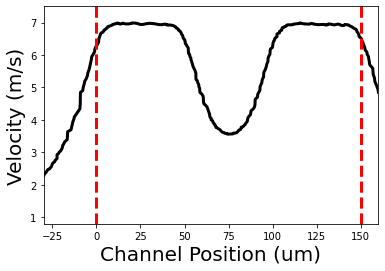

In [52]:
plt.plot(df_cm.x*1000,df_cm.v_avg,color='black',linewidth=3)

xposition = [0,150]

plt.xlabel('Channel Position (um)',size = 20)
plt.ylabel('Velocity (m/s)',size=20)
plt.xlim(-30,160)
plt.ylim(0.8,7.5)
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--',lw=3)

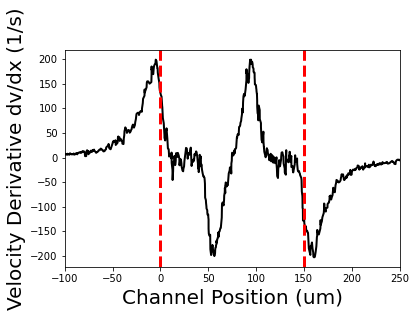

In [134]:
plt.plot(df_cm.x*1000,df_cm.dv_avg/1000,color='black',linewidth=2)

xposition = [0,150]

plt.xlabel('Channel Position (um)',size = 20)
plt.ylabel('Velocity Derivative dv/dx (1/s)',size=20)
plt.xlim(-100,250)

for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--',lw=3)
plt.show()

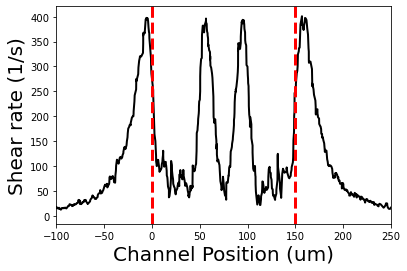

In [135]:
plt.plot(df_cm.x*1000,df_cm.sr_avg/1000,color='black',linewidth=2)

xposition = [0,150]

plt.xlabel('Channel Position (um)',size = 20)
plt.ylabel('Shear rate (1/s)',size=20)
plt.xlim(-100,250)

for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--',lw=3)
plt.show()

In [38]:
df['nar1max_x'] = df.apply(lambda x: x.xcm_um[x.nar1_max_arg],axis=1)
df['nar2max_x'] = df.apply(lambda x: x.xcm_um[x.nar2_max_arg],axis=1)
df['cav1min_x'] = df.apply(lambda x: x.xcm_um[x.cav1_min_arg],axis=1)

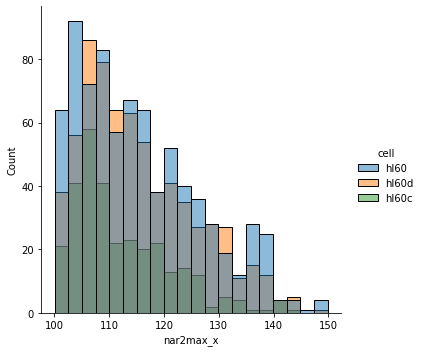

In [48]:
sns.displot(data=df,x = df.nar2max_x,hue = df.cell)

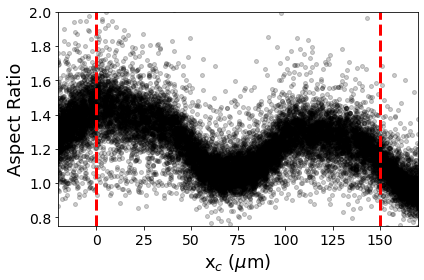

In [59]:
axis_size = 18
for i,row in df[df.cell=='hl60d'].iterrows():
    plt.scatter(row.xcm_um,row.aspect,color='black',alpha=0.2,s=16)
xposition = [0,150]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--',lw=3)
    
plt.xlabel('x$_{c}$ ($\mu$m)',size=axis_size)
plt.ylabel('Aspect Ratio',size=axis_size)

plt.tick_params(labelsize=14)
plt.xlim((-20,170))
plt.ylim((.75,2))
plt.tight_layout()